In [1]:
from ase.build import bulk, make_supercell
import numpy as np

from HopDec.Input import *
from HopDec.Lammps import *
from HopDec.State import *

import HopDec.Redecorate as Redecorate
import HopDec.Minimize as Minimize
import HopDec.NEB as NEB
import HopDec.MD as MD

%matplotlib inline
import matplotlib.pyplot as plt

# Generate Initial Structure (Vacancy in Pure Cu)

In [2]:
# Generate simple ASE structure

CuPrim = bulk('Cu', 'fcc', a=3.6, cubic=True)
CuPrim.cell
CuSuperCell = make_supercell(CuPrim, np.array([[5,0,0],[0,5,0],[0,0,5]]))

In [3]:
# Create Vacancy in supercell
del CuSuperCell[249]

In [4]:
CuSuperCell

Atoms(symbols='Cu499', pbc=True, cell=[18.0, 18.0, 18.0])

# Pass to Hop Dec

In [5]:
params = getParams()

In [6]:
# Initialize HopDec and transform ASE structure to State object

ase = ASE(params)
initialState = ase.toState(CuSuperCell)

In [7]:
# mininize State in-place

lmp = LammpsInterface(params)
Minimize.main(initialState, params, lmp = lmp, verbose = True)

[22/06/25, 13:30:31]:   Lammps >> Minimizing. F Tol: 1e-05.
[22/06/25, 13:30:31]: Lammps >> Completed Minimization, E: -1764.8919 eV


0.03035336407386224

# Find Transition

In [8]:
flag = 0
_, newState, flag = MD.main(initialState, params)

In [9]:
connection = NEB.main(initialState, newState, params, exportStructures = True, plotPathways = True, verbose = True) # run a NEB between these two states

[22/06/25, 13:30:33]: NEB >> Minimizing End Points
[22/06/25, 13:30:33]:   Lammps >> Minimizing. F Tol: 1e-05.
[22/06/25, 13:30:33]: Lammps >> Completed Minimization, E: -1764.8919 eV
[22/06/25, 13:30:33]:   Lammps >> Minimizing. F Tol: 1e-05.
[22/06/25, 13:30:33]: Lammps >> Completed Minimization, E: -1764.8919 eV
[22/06/25, 13:30:33]: NEB >> Initializing ASE Structure
[22/06/25, 13:30:33]: NEB >> Interpolating 11 images
[22/06/25, 13:30:33]: NEB >> Performing NEB. Force Tol: 0.1, Transition:
        ab2d71d992015e18300c2bc311585706 -> ab2d71d992015e18300c2bc311585706
[22/06/25, 13:30:33]: NEB >> NEB finished Successfully. Extracting Results
[22/06/25, 13:30:33]: NEB >> Checking NEB path for integrity
[22/06/25, 13:30:33]:   Lammps >> Minimizing. F Tol: 1e-05.
[22/06/25, 13:30:33]: Lammps >> Completed Minimization, E: -1764.8919 eV
[22/06/25, 13:30:33]:   Lammps >> Minimizing. F Tol: 1e-05.
[22/06/25, 13:30:33]: Lammps >> Completed Minimization, E: -1764.8919 eV
[22/06/25, 13:30:33]: 

In [10]:
connection.transitions[0].forwardBarrier

0.7411

# Redecorate Transition

In [11]:
# Given that we have found a valid Connection / Transition.
# We may want to run a redecoration campaign
# This one will take the States defined and conduct 10 NEBS (controlled in config file) 
# with redecoration of the atoms as either Cu or Ni at 50:50 concentrations (controlled in config file).
# Then return a results object
params.nDecorations = 2
redecResults = Redecorate.main(connection.transitions[0], params)

[22/06/25, 13:30:33]: Redecorate >> Starting NEB Redecoration Campaign
[22/06/25, 13:30:33]:   Redecorate >> rank: 0: Redecoration: 1
[22/06/25, 13:30:34]:   Redecorate >> rank: 0: Redecoration: 2


In [12]:
# The redecoration results contains 10 'Connection'.
# These 'connections' can be thought of as different decorations of the initial connection.
print(redecResults)
df = connection.transitions[0].loadRedecoration()
df

./eeab7a95621b6ee0a4e5192a14f18705_b1362ae7d67584bf486553e6aeb4ac1c


,Composition,Decoration,Transition,Initial State,Final State,Forward Barrier,Reverse Barrier,KRA,dE,Init Can Label,Init non-Can Label,Fin Can Label,Fin non-Can Label,Trans Can Label,Trans non-Can Label,Initial Energy,Final Energy
0,"0.5,0.5",1,1,<HopDec.State.State object at 0x12e9c3b60>,<HopDec.State.State object at 0x12e97f470>,0.7811,0.9327,0.8569,-0.1516,b059c077aca75409f67425870a12869f,345fd5b75cdbe6264c5f4e618cbae5c9,d6eb7fcd493ad0a58138107cef704d31,df170b73571a51c867dcb5fe5596da60,d5c6257b2d44996b567234db04929f7b,b1362ae7d67584bf486553e6aeb4ac1c,-1980.471855,-1980.623496
1,"0.5,0.5",2,1,<HopDec.State.State object at 0x12e97de20>,<HopDec.State.State object at 0x12e98df70>,0.7166,0.7904,0.7535,-0.0738,55dde47b67b6c92c337dee649be5ca4c,345fd5b75cdbe6264c5f4e618cbae5c9,15469e574914b1cf1684dec8c44a62ca,df170b73571a51c867dcb5fe5596da60,48e76ac5538cb206208599e87ef576fa,b1362ae7d67584bf486553e6aeb4ac1c,-1979.976632,-1980.050385


In [13]:
# the results object also contains the States of the redecorations
# In particular, this is the first redecoration and the first transition within that decoration.

df['Initial State']
df['Final State']

0    <HopDec.State.State object at 0x12e97f470>
1    <HopDec.State.State object at 0x12e98df70>
Name: Final State, dtype: object

# Calculate Barrier as a Function of Cu:Ni Ratio

In [14]:
initialState.write('0.dat')
newState.write('1.dat')

In [15]:
params = getParams()
initialState = read('0.dat')
finalState = read('1.dat')

In [16]:
lmp = LammpsInterface(params)
minDistInit = lmp.minimize(initialState, verbose = True)
minDistFin = lmp.minimize(finalState, verbose = True)

[22/06/25, 13:30:35]:   Lammps >> Minimizing. F Tol: 1e-05.
[22/06/25, 13:30:35]: Lammps >> Completed Minimization, E: -1764.8919 eV
[22/06/25, 13:30:35]:   Lammps >> Minimizing. F Tol: 1e-05.
[22/06/25, 13:30:35]: Lammps >> Completed Minimization, E: -1764.8919 eV


In [17]:
# Cu_{x}Ni_{1-x}
xVals = [1,0.75,0.5,0.25,0]
results  = []

params.nDecorations = 10
params.activeSpecies = ['Cu','Ni']
params.staticSpecies = []

tempTransition = Transition(initialState, finalState)

for x in xVals:

    print(f'Cu: {x}, Ni: {1-x}')
    params.concentration = [x, 1-x]
    
    redFilename = Redecorate.main(tempTransition, params)
    df = tempTransition.loadRedecoration()

    results.append(np.mean( df['Forward Barrier'].to_list() ))

Cu: 1, Ni: 0
[22/06/25, 13:30:35]: Redecorate >> Starting NEB Redecoration Campaign
[22/06/25, 13:30:35]:   Redecorate >> rank: 0: Redecoration: 1
[22/06/25, 13:30:36]:   Redecorate >> rank: 0: Redecoration: 2
[22/06/25, 13:30:36]:   Redecorate >> rank: 0: Redecoration: 3
[22/06/25, 13:30:37]:   Redecorate >> rank: 0: Redecoration: 4
[22/06/25, 13:30:38]:   Redecorate >> rank: 0: Redecoration: 5
[22/06/25, 13:30:38]:   Redecorate >> rank: 0: Redecoration: 6
[22/06/25, 13:30:39]:   Redecorate >> rank: 0: Redecoration: 7
[22/06/25, 13:30:40]:   Redecorate >> rank: 0: Redecoration: 8
[22/06/25, 13:30:40]:   Redecorate >> rank: 0: Redecoration: 9
[22/06/25, 13:30:41]:   Redecorate >> rank: 0: Redecoration: 10
Cu: 0.75, Ni: 0.25
[22/06/25, 13:30:41]: Redecorate >> Starting NEB Redecoration Campaign
[22/06/25, 13:30:41]:   Redecorate >> rank: 0: Redecoration: 1
[22/06/25, 13:30:42]:   Redecorate >> rank: 0: Redecoration: 2
[22/06/25, 13:30:43]:   Redecorate >> rank: 0: Redecoration: 3
[22/06

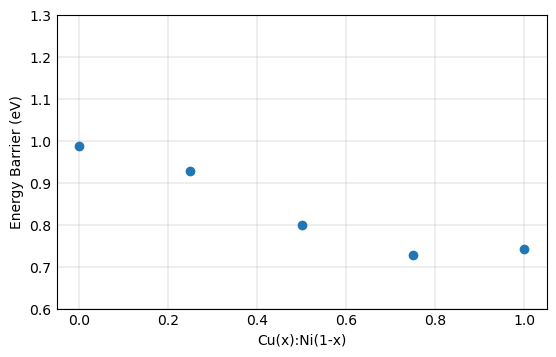

In [18]:
fig, axs = plt.subplots(1,1, figsize = (5,3))

axs.scatter(xVals, results)
axs.set_xlabel('Cu(x):Ni(1-x)')
axs.set_ylabel('Energy Barrier (eV)')
axs.set_ylim([0.6,1.3])

axs.grid(True, linewidth=0.3)